# Análisis por Período

#### Condiciones Iniciales:
 - Los Relevamientos se obtienen en varios csv
 - Debido al tiempo que se requiere para correr el scrapping puede que haya dos fechas para el mismo período (ponemos a correr el scrapper el 28 a la noche y termina el 29 a la mañana)
 - Los datos se guardan en una carpeta nombrada como le fecha del relevamiento (Ej: 20180928)
 - Internamente se guardan diversos csv que provienen de la estructura de scrapping que tenemos, todos cnon la misma estructura
 
#### Objetivo:

Un notebook que, a partir de fecha_inicio y fecha_fin, lea las carpetas de dicha fecha, levante los csv y realice comparativas de precios desde el inicio del periodo al fin del mismo.

#### Parámetros

In [1]:
fecha_inicio_relevamiento = "20180902" # Las fecha debe coincidir con nombres de carpetas
fecha_fin_relevamiento = "20180928" # Las fecha debe coincidir con nombres de carpetas

provincia_relevamiento = "AR-X" # Córdoba

sup_titulo_relevamiento = "Precios Septiembre '18"
titulo_relevamiento = "Relevamiento del Programa Precios Claros hecho por @opendatacba, para la provincia de Córdoba."


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
def obtener_path_archivos_de_precios(fecha):
    """Funcion para obtener el listado de archivos csv que almacenan los precios para el relevamiento
    hecho en la fecha pasada por parámetro"""
    
    files_to_read = []
    root_precios = os.path.join(".","datasets","precios", fecha)
    for root, dirs, files in os.walk(root_precios):
        for fname in files:
            files_to_read.append(os.path.join(root, fname))
            
    return(files_to_read)

In [4]:
def obtener_dataset_relevamiento(fecha, inicio_periodo):
    """Funcion que lee la carpeta correspondiente y devuelve un dataframe 
    conteniendo los datos del producto, del establecimiento relevado, el precio
    relevado y la fecha del relevamiento"""
        
    path_archivos_datos = obtener_path_archivos_de_precios(fecha)
    columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]

    precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in path_archivos_datos))

    precios = precios[precios["precio"].notnull()]

    # Piso la fecha en la cual se ejecuto el scrapper por la fecha del relevamiento (ver consideraciones)
    precios["fecha_relevamiento"] = pd.to_datetime(fecha)
    
    if inicio_periodo:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_inicio_periodo","precio": "precio_inicio_periodo"}, axis="columns", inplace=True)
    else:
        precios.rename({"fecha_relevamiento":"fecha_relevamiento_fin_periodo","precio": "precio_fin_periodo"}, axis="columns", inplace=True)   
    
    return(precios)

## Armar dataset comparativo para el Período

#### Cargar datasets de precios y comparar periodos

In [5]:
df_inicio = obtener_dataset_relevamiento(fecha_inicio_relevamiento, inicio_periodo=True)
df_fin = obtener_dataset_relevamiento(fecha_fin_relevamiento, inicio_periodo=False)

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_periodo", "precio_fin_periodo"]]
df_precios["variacion_periodo"] = round((df_precios["precio_fin_periodo"] / df_precios["precio_inicio_periodo"]) - 1,2)

#### Merge con datasets de Productos

In [6]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con datasets de Sucursales y filtrar por Córdoba

In [7]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == provincia_relevamiento]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Inspeccion final

In [8]:
df_precios.head()

,producto_id,sucursal_id,precio_inicio_periodo,precio_fin_periodo,variacion_periodo,nombre,marca,presentacion,localidad,sucursalNombre,direccion,sucursalTipo,empresa,cadena
0,7791675904474,15-1-1048,68.39,68.39,0.00,Aceitunas Verdes Descarozadas en Frasco Castel...,CASTELL,360.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
1,8480017328809,15-1-1048,17.69,18.99,0.07,Aceitunas Verdes Dia x 100 Gr,DIA,100.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
2,8480017110992,15-1-1048,39.99,39.99,0.00,Aceitunas Verdes Dia x 300 Gr,DIA,300.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
3,8480017062376,15-1-1048,69.99,69.99,0.00,Aceitunas Verdes Dia x 800 Gr,DIA,800.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA
4,7791675000169,15-1-1048,26.15,26.15,0.00,Aceitunas Verdes en Rodajas Doypack Castell 18...,CASTELL,180.0 gr,Bell Ville,1048 - Bell Ville,Cl Cordoba 602,Supermercado,DIA Argentina S.A,Supermercados DIA


### Analisis

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

In [10]:
# Si queremos leer desde el csv limpio
columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
tipo_columnas = ['category'] * len(columnas_categoricas)
col_types = dict(zip(columnas_categoricas, tipo_columnas))
df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

In [11]:
# Sacamos outliers
df_precios = df_precios[(df_precios.variacion_mensual > -0.20) & (df_precios.variacion_mensual < 0.30)]

In [12]:
df_precios.variacion_mensual.describe()

count    79009.000000
mean         0.087644
std          0.090616
min         -0.190000
25%          0.000000
50%          0.100000
75%          0.150000
max          0.290000
Name: variacion_mensual, dtype: float64

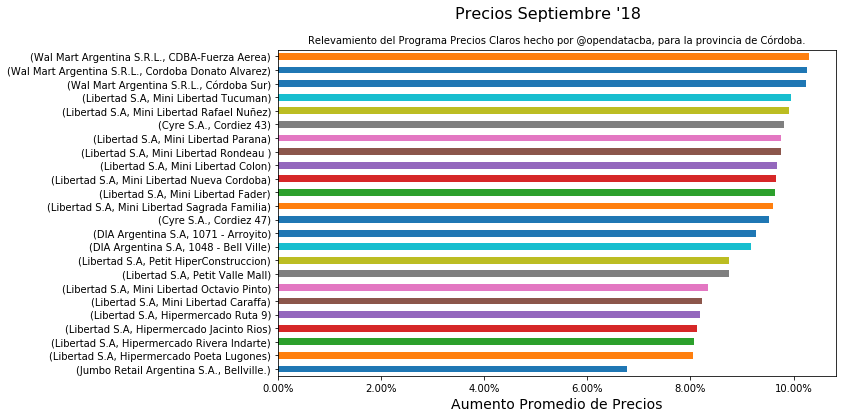

In [13]:
ax = df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios", size=14)
plt.show()

In [14]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values(ascending=False)

empresa                      sucursalNombre               
Wal Mart Argentina S.R.L.    CDBA-Fuerza Aerea                0.103053
                             Cordoba Donato Alvarez           0.102655
                             Córdoba Sur                      0.102452
Libertad S.A                 Mini Libertad Tucuman            0.099552
                             Mini Libertad Rafael Nuñez       0.099031
Cyre S.A.                    Cordiez 43                       0.098088
Libertad S.A                 Mini Libertad Parana             0.097595
                             Mini Libertad Rondeau            0.097491
                             Mini Libertad Colon              0.096860
                             Mini Libertad Nueva Cordoba      0.096536
                             Mini Libertad Fader              0.096388
                             Mini Libertad Sagrada Familia    0.096009
Cyre S.A.                    Cordiez 47                       0.095139
DIA Argentina S.A 

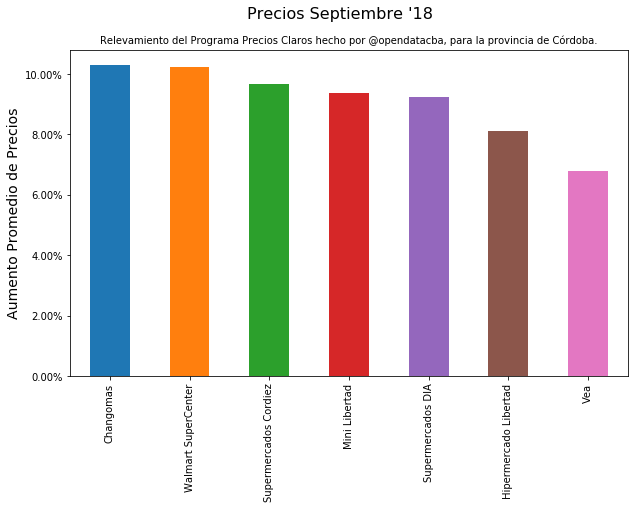

In [15]:
ax = df_precios.groupby(["cadena"])["variacion_mensual"].mean().sort_values(ascending=False).plot(kind="bar")
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.xlabel("")
plt.ylabel("Aumento Promedio de Precios", size=14)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

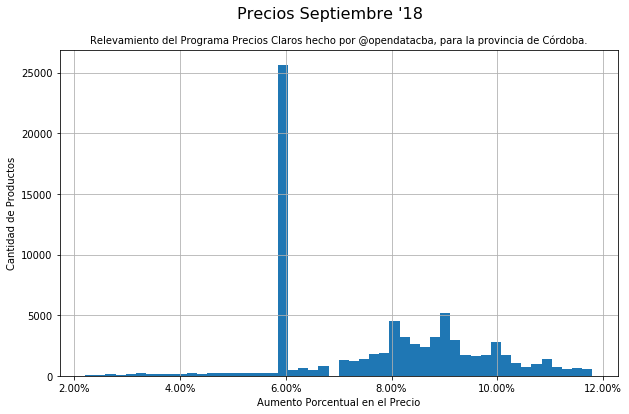

In [16]:
ax = df_precios.variacion_mensual.hist(bins=50)
plt.suptitle(sup_titulo_relevamiento, size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Cantidad de Productos")
plt.xlabel("Aumento Porcentual en el Precio")
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

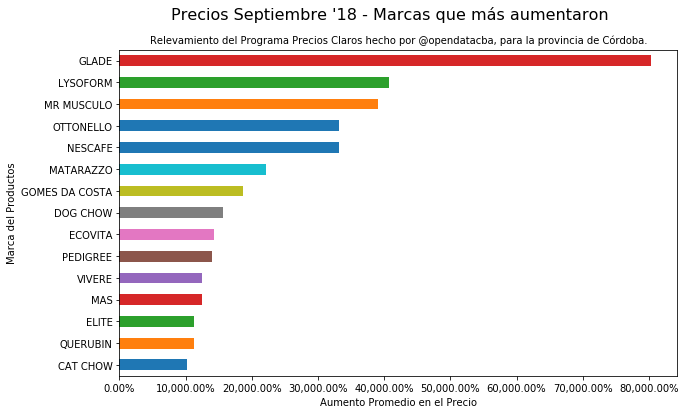

In [17]:
aumentos_marcas = df_precios.groupby("marca")["variacion_mensual"].agg({"mean", "count"}).sort_values(ascending=False, by="mean")
# Nos aseguramos que haya suficientes precios relevados como para que sea representativo el promedio
aumentos_marcas = aumentos_marcas[aumentos_marcas["count"] > 100]
aumentos_marcas.columns = ["cantidad_precios_relevados", "aumento_promedio"]

ax = aumentos_marcas.aumento_promedio.head(15).sort_values().plot(kind="barh")
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.suptitle(sup_titulo_relevamiento + " - Marcas que más aumentaron", size=16)
plt.title(titulo_relevamiento, size=10)
plt.ylabel("Marca del Productos")
plt.xlabel("Aumento Promedio en el Precio")
plt.show()

## Analisis Productos

In [18]:
def graficar_variacion_producto(df_producto, sup_title_producto):
    ax = df_producto["mean"].plot(kind="barh")
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.suptitle(sup_titulo_relevamiento + " - " + sup_title_producto, size=16)
    plt.title(titulo_relevamiento, size=10)
    plt.ylabel("")
    plt.xlabel("Aumento Promedio en el Precio", size=12)
    plt.show()

### Análisis Harinas

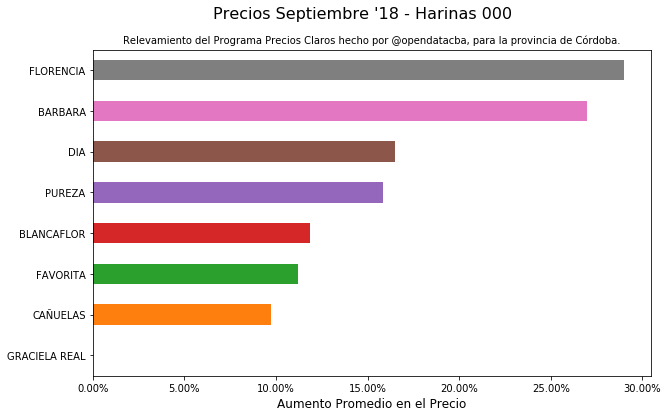

In [19]:
df_harinas = df_precios[df_precios.nombre.str.contains("Harina de Trigo 000")] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_harinas, "Harinas 000")

### Relevamiento Fideos

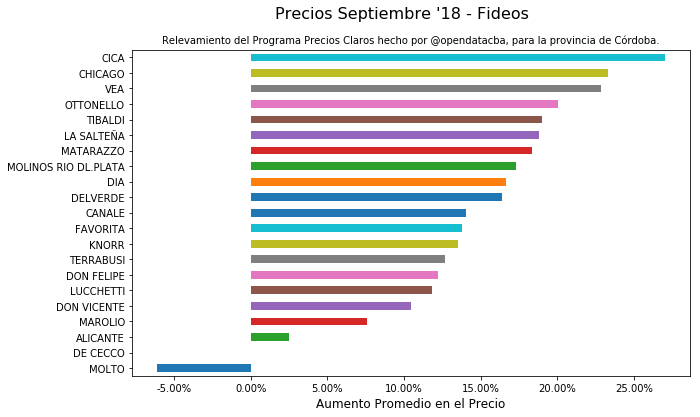

In [20]:
df_fideos = df_precios[df_precios.nombre.str.contains("Fideos")] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

df_fideos = df_fideos[df_fideos["count"] > 10]

graficar_variacion_producto(df_fideos, "Fideos")

### Relevamiento Aceite

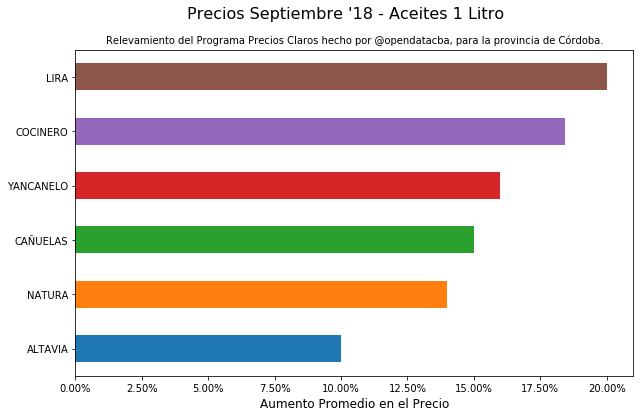

In [21]:
mask_aceites = df_precios.nombre.str.contains("Aceite")
mask_presentacion = df_precios.presentacion.str.contains("1.0 lt")

df_aceites = df_precios[mask_aceites & mask_presentacion] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")

graficar_variacion_producto(df_aceites, "Aceites 1 Litro")

### Relevamiento Azúcar

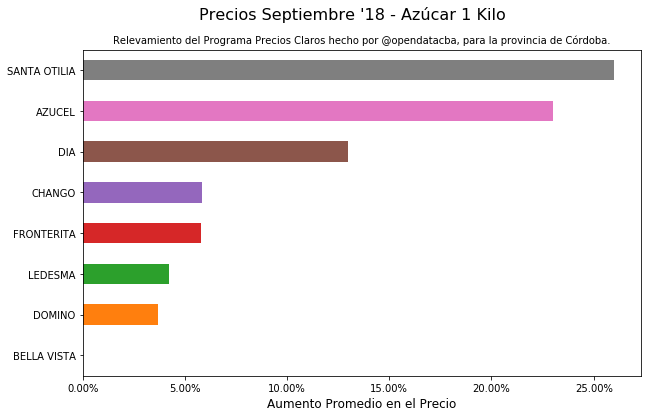

In [22]:
mask_azucar = df_precios.nombre.str.contains("^Azucar")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_azucar = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_azucar, "Azúcar 1 Kilo")

### Relevamiento Yerba

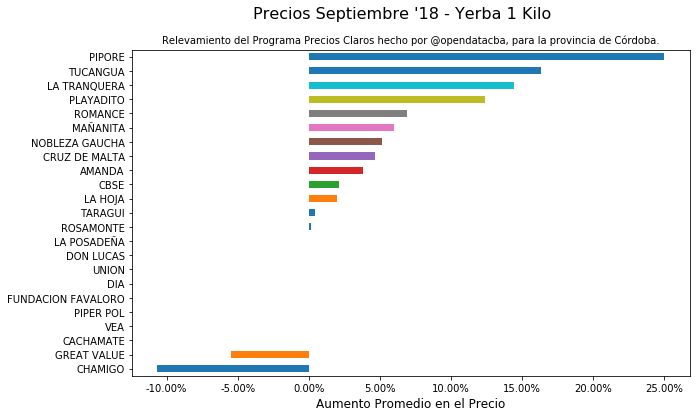

In [23]:
mask_azucar = df_precios.nombre.str.contains("^Yerba")
mask_presentacion_azucar = df_precios.presentacion.str.contains("1.0 kg")

df_yerba = df_precios[mask_azucar & mask_presentacion_azucar] \
    .groupby("marca", observed=True)["variacion_mensual"] \
    .agg({"mean","count"})\
    .sort_values(by="mean")
    
graficar_variacion_producto(df_yerba, "Yerba 1 Kilo")

## Tabla Comparativa Aumento Productos

In [24]:
df_harinas["producto"] = "Harinas"
df_aceites["producto"] = "Aceites"
df_fideos["producto"] = "Fideos"
df_azucar["producto"] = "Azucar"
df_yerba["producto"] = "Yerba"

df_productos = pd.concat([df_harinas, df_aceites, df_fideos, df_azucar])

df_productos.groupby("producto")["mean"].agg({"mean", "min", "max"}).sort_values(by="mean", ascending=False)

,max,mean,min
producto,,,
Aceites,0.20,0.155714,0.100000
Harinas,0.29,0.151414,0.000000
Fideos,0.27,0.139212,-0.060909
Azucar,0.26,0.101904,0.000000
